In [1]:
# import libraries
import time
import calendar
import numpy as np
import pandas as pd
from dateutil.parser import parse
from datetime import date, timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

import os

%matplotlib inline


In [2]:
data_dir = "data/"
air_visit = pd.read_csv(data_dir + "air_visit_data.csv")
air_reserve = pd.read_csv(data_dir + "air_reserve.csv")
hpg_reserve = pd.read_csv(data_dir + "hpg_reserve.csv")
air_store  = pd.read_csv(data_dir + "air_store_info.csv")
hpg_store = pd.read_csv(data_dir + "hpg_store_info.csv")
date_info = pd.read_csv(data_dir + "date_info.csv")
store_id_map  = pd.read_csv(data_dir + "store_id_relation.csv")
submission = pd.read_csv(data_dir + "sample_submission.csv")

In [3]:
air_visit

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6
...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6
252104,air_24e8414b9b07decb,2017-04-19,6
252105,air_24e8414b9b07decb,2017-04-20,7
252106,air_24e8414b9b07decb,2017-04-21,8


In [4]:
submission

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0
...,...,...
32014,air_fff68b929994bfbd_2017-05-27,0
32015,air_fff68b929994bfbd_2017-05-28,0
32016,air_fff68b929994bfbd_2017-05-29,0
32017,air_fff68b929994bfbd_2017-05-30,0


In [5]:
# define utility funtions
def rmsle(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

calendar.setfirstweekday(6)
def get_week_of_month(date_str):
    year = int(date_str[:4])
    month = int(date_str[5:7])
    day = int(date_str[8:10])
    x = np.array(calendar.monthcalendar(year, month))
    week_of_month = np.where(x==day)[0][0] + 1
    return(week_of_month)


In [6]:
air_visit_count = len(air_visit)

train_data = air_visit.copy()
test_data = submission.copy()

test_data["air_store_id"] = test_data.apply(lambda x: '_'.join(x['id'].split('_')[:2]), axis=1)
test_data["visit_date"] = test_data.apply(lambda x:x['id'].split("_")[-1], axis=1)
test_data.drop("id",axis=1, inplace=True)

concat_data = pd.concat([train_data, test_data])
concat_data

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6
...,...,...,...
32014,air_fff68b929994bfbd,2017-05-27,0
32015,air_fff68b929994bfbd,2017-05-28,0
32016,air_fff68b929994bfbd,2017-05-29,0
32017,air_fff68b929994bfbd,2017-05-30,0


In [7]:
concat_data = pd.merge(concat_data, date_info, how="left", left_on="visit_date", right_on="calendar_date")
concat_data.drop("calendar_date", axis=1, inplace=True)
concat_data.head()



,air_store_id,visit_date,visitors,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0


In [8]:
print(len(air_store))
print(len(store_id_map))

829
150


There are only 150 hpg_stores that match air_store. It may be necessary to deal with missing values ​​later



In [9]:
concat_data = pd.merge(concat_data, air_store, how="left", on="air_store_id")
concat_data = pd.merge(concat_data, store_id_map, how="left", on="air_store_id")
concat_data = pd.merge(concat_data, hpg_store, how="left", on="hpg_store_id")
concat_data.head()


,air_store_id,visit_date,visitors,day_of_week,holiday_flg,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_y,longitude_y
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN


In [10]:
air_reserve_data = air_reserve.copy()
air_reserve_data["visit_datetime"] = air_reserve_data["visit_datetime"].str[:10]
air_reserve_data = air_reserve_data[["air_store_id", "visit_datetime", "reserve_visitors"]] \
                        .groupby(by=["air_store_id", 'visit_datetime']) \
                        .sum() \
                        .reset_index()
air_reserve_data = air_reserve_data.rename(columns = {'reserve_visitors': 'air_reserve_visitors'})
air_reserve_data = air_reserve_data.rename(columns = {'visit_datetime': 'visit_date'})

pd.merge(concat_data, air_reserve_data, how="left", on=['air_store_id', 'visit_date'])
 
concat_data = pd.merge(concat_data, air_reserve_data, how="left", on=['air_store_id', 'visit_date'])

In [11]:
concat_data

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_y,longitude_y,air_reserve_visitors
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284122,air_fff68b929994bfbd,2017-05-27,0,Saturday,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,NaN,NaN,NaN
284123,air_fff68b929994bfbd,2017-05-28,0,Sunday,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,NaN,NaN,NaN
284124,air_fff68b929994bfbd,2017-05-29,0,Monday,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,NaN,NaN,NaN
284125,air_fff68b929994bfbd,2017-05-30,0,Tuesday,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
hpg_reserve_data = hpg_reserve.copy()
hpg_reserve_data["visit_datetime"] = hpg_reserve_data["visit_datetime"].str[:10]
hpg_reserve_data = hpg_reserve_data[["hpg_store_id", "visit_datetime", "reserve_visitors"]] \
                        .groupby(by=["hpg_store_id", 'visit_datetime']) \
                        .sum() \
                        .reset_index()
hpg_reserve_data = hpg_reserve_data.rename(columns = {'reserve_visitors': 'hpg_reserve_visitors'})
hpg_reserve_data = hpg_reserve_data.rename(columns = {'visit_datetime': 'visit_date'})
hpg_reserve_data["visit_date"] = hpg_reserve_data["visit_date"].str[:10]

concat_data = pd.merge(concat_data, hpg_reserve_data, how="left", on=['hpg_store_id', 'visit_date'])


In [13]:
concat_data

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_y,longitude_y,air_reserve_visitors,hpg_reserve_visitors
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284122,air_fff68b929994bfbd,2017-05-27,0,Saturday,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,NaN,NaN,NaN,NaN
284123,air_fff68b929994bfbd,2017-05-28,0,Sunday,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,NaN,NaN,NaN,NaN
284124,air_fff68b929994bfbd,2017-05-29,0,Monday,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,NaN,NaN,NaN,NaN
284125,air_fff68b929994bfbd,2017-05-30,0,Tuesday,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
concat_data.isna().sum()

air_store_id                 0
visit_date                   0
visitors                     0
day_of_week                  0
holiday_flg                  0
air_genre_name               0
air_area_name                0
latitude_x                   0
longitude_x                  0
hpg_store_id            232258
hpg_genre_name          261572
hpg_area_name           261572
latitude_y              261572
longitude_y             261572
air_reserve_visitors    254932
hpg_reserve_visitors    270247
dtype: int64

In [15]:
concat_data = concat_data.drop(["hpg_area_name", "hpg_genre_name", "latitude_y", "longitude_y"], axis=1)

In [16]:
query = "air_reserve_visitors.notnull() and hpg_reserve_visitors.notnull() and air_reserve_visitors!=hpg_reserve_visitors"
concat_data.query(query,engine='python').head()

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,air_reserve_visitors,hpg_reserve_visitors
4669,air_3e93f3c81008696d,2016-10-27,48,Thursday,0,Okonomiyaki/Monja/Teppanyaki,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386244,132.455018,hpg_c2a8494d55fafbd6,12.0,2.0
4670,air_3e93f3c81008696d,2016-10-28,25,Friday,0,Okonomiyaki/Monja/Teppanyaki,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386244,132.455018,hpg_c2a8494d55fafbd6,4.0,2.0
4671,air_3e93f3c81008696d,2016-10-29,42,Saturday,0,Okonomiyaki/Monja/Teppanyaki,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386244,132.455018,hpg_c2a8494d55fafbd6,17.0,28.0
4673,air_3e93f3c81008696d,2016-11-01,76,Tuesday,0,Okonomiyaki/Monja/Teppanyaki,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386244,132.455018,hpg_c2a8494d55fafbd6,74.0,3.0
4676,air_3e93f3c81008696d,2016-11-04,5,Friday,0,Okonomiyaki/Monja/Teppanyaki,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386244,132.455018,hpg_c2a8494d55fafbd6,11.0,7.0


In [17]:
concat_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284127 entries, 0 to 284126
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   air_store_id          284127 non-null  object 
 1   visit_date            284127 non-null  object 
 2   visitors              284127 non-null  int64  
 3   day_of_week           284127 non-null  object 
 4   holiday_flg           284127 non-null  int64  
 5   air_genre_name        284127 non-null  object 
 6   air_area_name         284127 non-null  object 
 7   latitude_x            284127 non-null  float64
 8   longitude_x           284127 non-null  float64
 9   hpg_store_id          51869 non-null   object 
 10  air_reserve_visitors  29195 non-null   float64
 11  hpg_reserve_visitors  13880 non-null   float64
dtypes: float64(4), int64(2), object(6)
memory usage: 28.2+ MB


The columns air_store_id, visit_date, day_of_week, air_genre_name, and air_area_name are in a data type that cannot be operated on.

In [18]:
# dayofweek : monday(0)~sunday(6)
# Convert date data

concat_data['visit_date'] = pd.to_datetime(concat_data['visit_date'])
concat_data['visit_day_of_week'] = pd.to_datetime(concat_data['visit_date']).dt.dayofweek
concat_data['day'] = concat_data['visit_date'].dt.day
concat_data['dow'] = concat_data['visit_date'].dt.weekday # monday:0, sunday:6
concat_data['year'] = concat_data['visit_date'].dt.year
concat_data['month'] = concat_data['visit_date'].dt.month
concat_data['week'] = concat_data['visit_date'].dt.week
concat_data['quarter'] = concat_data['visit_date'].dt.quarter
concat_data['visit_date'] = concat_data['visit_date'].dt.date

/var/folders/3f/t2z7k3f5209_6hp246wpbpg40000gn/T/ipykernel_28886/2498725667.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  concat_data['week'] = concat_data['visit_date'].dt.week


In [19]:
concat_data

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,air_reserve_visitors,hpg_reserve_visitors,visit_day_of_week,day,dow,year,month,week,quarter
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,2,13,2,2016,1,2,1
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,3,14,3,2016,1,2,1
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,4,15,4,2016,1,2,1
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,5,16,5,2016,1,2,1
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,0,18,0,2016,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284122,air_fff68b929994bfbd,2017-05-27,0,Saturday,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,5,27,5,2017,5,21,2
284123,air_fff68b929994bfbd,2017-05-28,0,Sunday,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,6,28,6,2017,5,21,2
284124,air_fff68b929994bfbd,2017-05-29,0,Monday,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,0,29,0,2017,5,22,2
284125,air_fff68b929994bfbd,2017-05-30,0,Tuesday,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,1,30,1,2017,5,22,2


In [20]:
# Add weekend data
concat_data['weekend_flg'] = ((concat_data['visit_day_of_week']>4)).astype(int)

In [21]:
concat_data

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,air_reserve_visitors,hpg_reserve_visitors,visit_day_of_week,day,dow,year,month,week,quarter,weekend_flg
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,2,13,2,2016,1,2,1,0
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,3,14,3,2016,1,2,1,0
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,4,15,4,2016,1,2,1,0
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,5,16,5,2016,1,2,1,1
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,0,18,0,2016,1,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284122,air_fff68b929994bfbd,2017-05-27,0,Saturday,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,5,27,5,2017,5,21,2,1
284123,air_fff68b929994bfbd,2017-05-28,0,Sunday,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,6,28,6,2017,5,21,2,1
284124,air_fff68b929994bfbd,2017-05-29,0,Monday,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,0,29,0,2017,5,22,2,0
284125,air_fff68b929994bfbd,2017-05-30,0,Tuesday,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,1,30,1,2017,5,22,2,0


In [22]:
# Due to the nature of Japanese holidays (Happy Monday), data on the week of the month is added.
concat_data["visit_week_of_month"] = concat_data["visit_date"].apply(str).apply(get_week_of_month)

In [23]:
# One-hot encoding the day of the week
concat_data = pd.get_dummies(concat_data, columns = ['day_of_week'], prefix="", prefix_sep='')

In [24]:
concat_data

,air_store_id,visit_date,visitors,holiday_flg,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,air_reserve_visitors,...,quarter,weekend_flg,visit_week_of_month,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,air_ba937bf13d40fb24,2016-01-13,25,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,1,0,3,0,0,0,0,0,0,1
1,air_ba937bf13d40fb24,2016-01-14,32,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,1,0,3,0,0,0,0,1,0,0
2,air_ba937bf13d40fb24,2016-01-15,29,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,1,0,3,1,0,0,0,0,0,0
3,air_ba937bf13d40fb24,2016-01-16,22,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,1,1,3,0,0,1,0,0,0,0
4,air_ba937bf13d40fb24,2016-01-18,6,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,1,0,4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284122,air_fff68b929994bfbd,2017-05-27,0,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,...,2,1,4,0,0,1,0,0,0,0
284123,air_fff68b929994bfbd,2017-05-28,0,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,...,2,1,5,0,0,0,1,0,0,0
284124,air_fff68b929994bfbd,2017-05-29,0,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,...,2,0,5,0,1,0,0,0,0,0
284125,air_fff68b929994bfbd,2017-05-30,0,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,...,2,0,5,0,0,0,0,0,1,0


In [25]:
# Add column for days off regardless of weekend/holiday
concat_data['off_day_flg'] = ((concat_data['weekend_flg']==1) | (concat_data['holiday_flg']==1)).astype(int)

In [26]:
# Add a column to determine if the next day is a holiday
concat_data['next_day_is_off'] = concat_data['off_day_flg'].shift(-1,fill_value=0).astype(int)


In [27]:
# Add Golden Week flag
# 2016 Golden Week is from 4/29 to 5/5
# 2017 Golden Week is from 4/29 to 5/5

concat_data['golden_week_flg'] = ( \
                                  ((concat_data['visit_date'].apply(str)>='2016-04-29') & (concat_data['visit_date'].apply(str)<='2016-05-05')) | \
                                  ((concat_data['visit_date'].apply(str)>='2017-04-29') & (concat_data['visit_date'].apply(str)<='2017-05-05'))
                                 ).astype(int)

concat_data.head(1)

,air_store_id,visit_date,visitors,holiday_flg,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,air_reserve_visitors,...,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,off_day_flg,next_day_is_off,golden_week_flg
0,air_ba937bf13d40fb24,2016-01-13,25,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0


In [28]:
test_data

,visitors,air_store_id,visit_date
0,0,air_00a91d42b08b08d9,2017-04-23
1,0,air_00a91d42b08b08d9,2017-04-24
2,0,air_00a91d42b08b08d9,2017-04-25
3,0,air_00a91d42b08b08d9,2017-04-26
4,0,air_00a91d42b08b08d9,2017-04-27
...,...,...,...
32014,0,air_fff68b929994bfbd,2017-05-27
32015,0,air_fff68b929994bfbd,2017-05-28
32016,0,air_fff68b929994bfbd,2017-05-29
32017,0,air_fff68b929994bfbd,2017-05-30


In [29]:
unique_stores = test_data['air_store_id'].unique()#extract unique stores id from test data

In [30]:
unique_stores

array(['air_00a91d42b08b08d9', 'air_0164b9927d20bcc3',
       'air_0241aa3964b7f861', 'air_0328696196e46f18',
       'air_034a3d5b40d5b1b1', 'air_036d4f1ee7285390',
       'air_0382c794b73b51ad', 'air_03963426c9312048',
       'air_04341b588bde96cd', 'air_049f6d5b402a31b2',
       'air_04cae7c1bc9b2a0b', 'air_0585011fa179bcce',
       'air_05c325d315cc17f5', 'air_0647f17b4dc041c8',
       'air_064e203265ee5753', 'air_066f0221b8a4d533',
       'air_06f95ac5c33aca10', 'air_0728814bd98f7367',
       'air_0768ab3910f7967f', 'air_07b314d83059c4d2',
       'air_07bb665f9cdfbdfb', 'air_082908692355165e',
       'air_083ddc520ea47e1e', 'air_0845d8395f30c6bb',
       'air_084d98859256acf0', 'air_0867f7bebad6a649',
       'air_08ba8cd01b3ba010', 'air_08cb3c4ee6cd6a22',
       'air_08ef81d5b7a0d13f', 'air_08f994758a1e76d4',
       'air_09040f6df960ddb8', 'air_0919d54f0c9a24b8',
       'air_09661c0f3259cc04', 'air_09a845d5b5944b01',
       'air_09fd1f5c58583141', 'air_0a74a5408a0b8642',
       'ai

In [31]:
# Add daily visitor statistics for each store as a feature
store_7days = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) 
                    for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)
store_7days

,air_store_id,dow
0,air_00a91d42b08b08d9,0
1,air_0164b9927d20bcc3,0
2,air_0241aa3964b7f861,0
3,air_0328696196e46f18,0
4,air_034a3d5b40d5b1b1,0
...,...,...
5742,air_fea5dc9594450608,6
5743,air_fee8dcf4d619598e,6
5744,air_fef9ccb3ba0da2f7,6
5745,air_ffcc2d5087e1b476,6


In [32]:
store_sum = pd.DataFrame({'air_store_id': unique_stores})

In [33]:
store_sum

,air_store_id
0,air_00a91d42b08b08d9
1,air_0164b9927d20bcc3
2,air_0241aa3964b7f861
3,air_0328696196e46f18
4,air_034a3d5b40d5b1b1
...,...
816,air_fea5dc9594450608
817,air_fee8dcf4d619598e
818,air_fef9ccb3ba0da2f7
819,air_ffcc2d5087e1b476


In [34]:
tmp = concat_data.groupby(['air_store_id'], as_index=False)[
    'visitors'].sum().rename(columns={'visitors':'total_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id']) 
tmp = concat_data.groupby(['air_store_id','dow'], as_index=False)[
    'visitors'].mean().rename(columns={'visitors':'mean_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])
tmp = concat_data.groupby(['air_store_id','dow'], as_index=False)[
    'visitors'].median().rename(columns={'visitors':'median_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])
tmp = concat_data.groupby(['air_store_id','dow'], as_index=False)[
    'visitors'].max().rename(columns={'visitors':'max_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])
tmp = concat_data.groupby(['air_store_id','dow'], as_index=False)[
    'visitors'].count().rename(columns={'visitors':'count_observations'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow']) 

# store_7days
# concat_data
concat_data = pd.merge(concat_data, store_7days, how='left', on=['air_store_id','dow'])

concat_data["total_visitors"] = concat_data["total_visitors"].fillna(0)
concat_data["mean_visitors"] = concat_data["mean_visitors"].fillna(0)
concat_data["median_visitors"] = concat_data["median_visitors"].fillna(0)
concat_data["max_visitors"] = concat_data["max_visitors"].fillna(0)
concat_data["count_observations"] = concat_data["count_observations"].fillna(0)


In [35]:
concat_data

,air_store_id,visit_date,visitors,holiday_flg,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,air_reserve_visitors,...,Tuesday,Wednesday,off_day_flg,next_day_is_off,golden_week_flg,total_visitors,mean_visitors,median_visitors,max_visitors,count_observations
0,air_ba937bf13d40fb24,2016-01-13,25,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,0,1,0,0,0,8908.0,21.800000,24.0,57.0,70.0
1,air_ba937bf13d40fb24,2016-01-14,32,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,0,0,0,0,0,8908.0,18.842857,20.0,54.0,70.0
2,air_ba937bf13d40fb24,2016-01-15,29,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,0,0,0,1,0,8908.0,32.257143,33.0,61.0,70.0
3,air_ba937bf13d40fb24,2016-01-16,22,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,0,0,1,0,0,8908.0,25.704225,26.0,53.0,71.0
4,air_ba937bf13d40fb24,2016-01-18,6,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,0,0,0,0,0,8908.0,12.444444,11.0,34.0,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284122,air_fff68b929994bfbd,2017-05-27,0,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,...,0,0,1,1,0,1369.0,6.630435,6.5,18.0,46.0
284123,air_fff68b929994bfbd,2017-05-28,0,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,...,0,0,1,0,0,1369.0,3.333333,3.0,10.0,36.0
284124,air_fff68b929994bfbd,2017-05-29,0,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,...,0,0,0,0,0,1369.0,3.585366,3.0,14.0,41.0
284125,air_fff68b929994bfbd,2017-05-30,0,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,...,1,0,0,0,0,1369.0,3.909091,4.0,11.0,44.0


In [36]:
# Add a feature for each store, compared to the previous quarter

qoq= concat_data.groupby(['air_store_id','year','quarter'])['visitors'].sum()
qoq=qoq.unstack(0)
qoq=pd.DataFrame(qoq.to_records())
qoq=qoq.transpose()
qoq.drop(['year','quarter'],inplace=True)
qoq['2016Q2']=qoq[1]/qoq[0]*100
qoq['2016Q3']=qoq[2]/qoq[1]*100
qoq['2016Q4']=qoq[3]/qoq[2]*100
qoq['2017Q1']=qoq[4]/qoq[3]*100
lst=['2016Q2','2016Q3','2016Q4','2017Q1']
qoq=qoq[lst]
qoq['qoq_count']=qoq.apply(lambda x: x.count(), axis=1) 
qoq['qoq_growth']=qoq.apply(lambda x: x[x>100].count(), axis=1)
qoq['qoq_growth_pct'] = round(qoq['qoq_growth'] /qoq['qoq_count'],2)
qoq.index.names=['air_store_id']
qoq.reset_index(inplace=True)
qoq = qoq.fillna(0) #change to one for algo training

concat_data = pd.merge(concat_data, qoq, how='left', on='air_store_id')

In [37]:
concat_data

,air_store_id,visit_date,visitors,holiday_flg,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,air_reserve_visitors,...,median_visitors,max_visitors,count_observations,2016Q2,2016Q3,2016Q4,2017Q1,qoq_count,qoq_growth,qoq_growth_pct
0,air_ba937bf13d40fb24,2016-01-13,25,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,24.0,57.0,70.0,144.475524,93.901258,87.731959,82.667450,4,1,0.25
1,air_ba937bf13d40fb24,2016-01-14,32,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,20.0,54.0,70.0,144.475524,93.901258,87.731959,82.667450,4,1,0.25
2,air_ba937bf13d40fb24,2016-01-15,29,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,33.0,61.0,70.0,144.475524,93.901258,87.731959,82.667450,4,1,0.25
3,air_ba937bf13d40fb24,2016-01-16,22,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,26.0,53.0,71.0,144.475524,93.901258,87.731959,82.667450,4,1,0.25
4,air_ba937bf13d40fb24,2016-01-18,6,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,11.0,34.0,63.0,144.475524,93.901258,87.731959,82.667450,4,1,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284122,air_fff68b929994bfbd,2017-05-27,0,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,...,6.5,18.0,46.0,0.000000,0.000000,111.881188,90.929204,2,1,0.50
284123,air_fff68b929994bfbd,2017-05-28,0,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,...,3.0,10.0,36.0,0.000000,0.000000,111.881188,90.929204,2,1,0.50
284124,air_fff68b929994bfbd,2017-05-29,0,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,...,3.0,14.0,41.0,0.000000,0.000000,111.881188,90.929204,2,1,0.50
284125,air_fff68b929994bfbd,2017-05-30,0,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,...,4.0,11.0,44.0,0.000000,0.000000,111.881188,90.929204,2,1,0.50


In [38]:
# Is it Friday/Saturday? (See EDA)

concat_data['pre_weekend_flg'] = ((concat_data['visit_day_of_week']>3) & (concat_data['visit_day_of_week']<6)).astype(int)


In [39]:
concat_data['off_day_flg'] = ((concat_data['weekend_flg']==1) | (concat_data['holiday_flg']==1)).astype(int)
concat_data['next_day_is_off_day'] = concat_data['off_day_flg'].shift(-1,fill_value=0).astype(int)

In [40]:
concat_data

,air_store_id,visit_date,visitors,holiday_flg,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,air_reserve_visitors,...,count_observations,2016Q2,2016Q3,2016Q4,2017Q1,qoq_count,qoq_growth,qoq_growth_pct,pre_weekend_flg,next_day_is_off_day
0,air_ba937bf13d40fb24,2016-01-13,25,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,70.0,144.475524,93.901258,87.731959,82.667450,4,1,0.25,0,0
1,air_ba937bf13d40fb24,2016-01-14,32,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,70.0,144.475524,93.901258,87.731959,82.667450,4,1,0.25,0,0
2,air_ba937bf13d40fb24,2016-01-15,29,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,70.0,144.475524,93.901258,87.731959,82.667450,4,1,0.25,1,1
3,air_ba937bf13d40fb24,2016-01-16,22,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,71.0,144.475524,93.901258,87.731959,82.667450,4,1,0.25,1,0
4,air_ba937bf13d40fb24,2016-01-18,6,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,63.0,144.475524,93.901258,87.731959,82.667450,4,1,0.25,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284122,air_fff68b929994bfbd,2017-05-27,0,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,...,46.0,0.000000,0.000000,111.881188,90.929204,2,1,0.50,1,1
284123,air_fff68b929994bfbd,2017-05-28,0,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,...,36.0,0.000000,0.000000,111.881188,90.929204,2,1,0.50,0,0
284124,air_fff68b929994bfbd,2017-05-29,0,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,...,41.0,0.000000,0.000000,111.881188,90.929204,2,1,0.50,0,0
284125,air_fff68b929994bfbd,2017-05-30,0,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,...,44.0,0.000000,0.000000,111.881188,90.929204,2,1,0.50,0,0


In [41]:
concat_data["today_off_next_day_working"] =  ((concat_data['off_day_flg']==1) | (concat_data['next_day_is_off_day']==0)).astype(int)

In [42]:
concat_data = pd.get_dummies(concat_data, columns = ['air_genre_name'], prefix="", prefix_sep='')

In [43]:
concat_data

,air_store_id,visit_date,visitors,holiday_flg,air_area_name,latitude_x,longitude_x,hpg_store_id,air_reserve_visitors,hpg_reserve_visitors,...,Dining bar,International cuisine,Italian/French,Izakaya,Japanese food,Karaoke/Party,Okonomiyaki/Monja/Teppanyaki,Other,Western food,Yakiniku/Korean food
0,air_ba937bf13d40fb24,2016-01-13,25,0,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
1,air_ba937bf13d40fb24,2016-01-14,32,0,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
2,air_ba937bf13d40fb24,2016-01-15,29,0,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
3,air_ba937bf13d40fb24,2016-01-16,22,0,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
4,air_ba937bf13d40fb24,2016-01-18,6,0,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284122,air_fff68b929994bfbd,2017-05-27,0,0,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
284123,air_fff68b929994bfbd,2017-05-28,0,0,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
284124,air_fff68b929994bfbd,2017-05-29,0,0,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
284125,air_fff68b929994bfbd,2017-05-30,0,0,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [44]:
concat_data["area_1"] = concat_data["air_area_name"].str.split(" ").str[0]
concat_data["area_2"] = concat_data["air_area_name"].str.split(" ").str[1]
concat_data["area_3"] = concat_data["air_area_name"].str.split(" ").str[2]

concat_data = pd.get_dummies(concat_data, columns = ['area_1'], prefix="", prefix_sep='')
concat_data = pd.get_dummies(concat_data, columns = ['area_2'], prefix="", prefix_sep='')
concat_data = pd.get_dummies(concat_data, columns = ['area_3'], prefix="", prefix_sep='')


In [45]:
concat_data

,air_store_id,visit_date,visitors,holiday_flg,air_area_name,latitude_x,longitude_x,hpg_store_id,air_reserve_visitors,hpg_reserve_visitors,...,Toyotamakita,Tsukiji,Tōyō,Tōyōchō,Yasuda,Ōgimachi,Ōhiraki,Ōjihonchō,Ōtedōri,Ōtemachi
0,air_ba937bf13d40fb24,2016-01-13,25,0,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,air_ba937bf13d40fb24,2016-01-14,32,0,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,air_ba937bf13d40fb24,2016-01-15,29,0,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,air_ba937bf13d40fb24,2016-01-16,22,0,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,air_ba937bf13d40fb24,2016-01-18,6,0,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284122,air_fff68b929994bfbd,2017-05-27,0,0,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
284123,air_fff68b929994bfbd,2017-05-28,0,0,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
284124,air_fff68b929994bfbd,2017-05-29,0,0,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
284125,air_fff68b929994bfbd,2017-05-30,0,0,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [46]:
air_visit.sort_values(by="visitors", ascending=False).head()

,air_store_id,visit_date,visitors
85314,air_cfdeb326418194ff,2017-03-08,877
214825,air_8c3175aa5e4fc569,2017-04-18,777
72836,air_f2985de32bb792e0,2016-07-10,675
172123,air_eca5e0064dc9314a,2016-08-30,627
143894,air_43d577e0c9460e64,2016-01-24,514


In [47]:
concat_data.sort_values("air_reserve_visitors").tail()

,air_store_id,visit_date,visitors,holiday_flg,air_area_name,latitude_x,longitude_x,hpg_store_id,air_reserve_visitors,hpg_reserve_visitors,...,Toyotamakita,Tsukiji,Tōyō,Tōyōchō,Yasuda,Ōgimachi,Ōhiraki,Ōjihonchō,Ōtedōri,Ōtemachi
284122,air_fff68b929994bfbd,2017-05-27,0,0,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
284123,air_fff68b929994bfbd,2017-05-28,0,0,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
284124,air_fff68b929994bfbd,2017-05-29,0,0,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
284125,air_fff68b929994bfbd,2017-05-30,0,0,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
284126,air_fff68b929994bfbd,2017-05-31,0,0,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [48]:
without_columns = ["air_store_id", "visit_date", "day_of_week", "visit_day_of_week", "air_area_name", "hpg_store_id", "area_1", "area_2", "area_3"]
selected_columns = [x for x in concat_data.columns if x not in without_columns]
train_data = concat_data[selected_columns]


In [49]:
train_data

,visitors,holiday_flg,latitude_x,longitude_x,air_reserve_visitors,hpg_reserve_visitors,day,dow,year,month,...,Toyotamakita,Tsukiji,Tōyō,Tōyōchō,Yasuda,Ōgimachi,Ōhiraki,Ōjihonchō,Ōtedōri,Ōtemachi
0,25,0,35.658068,139.751599,NaN,NaN,13,2,2016,1,...,0,0,0,0,0,0,0,0,0,0
1,32,0,35.658068,139.751599,NaN,NaN,14,3,2016,1,...,0,0,0,0,0,0,0,0,0,0
2,29,0,35.658068,139.751599,NaN,NaN,15,4,2016,1,...,0,0,0,0,0,0,0,0,0,0
3,22,0,35.658068,139.751599,NaN,NaN,16,5,2016,1,...,0,0,0,0,0,0,0,0,0,0
4,6,0,35.658068,139.751599,NaN,NaN,18,0,2016,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284122,0,0,35.708146,139.666288,NaN,NaN,27,5,2017,5,...,0,0,0,0,0,0,0,0,0,0
284123,0,0,35.708146,139.666288,NaN,NaN,28,6,2017,5,...,0,0,0,0,0,0,0,0,0,0
284124,0,0,35.708146,139.666288,NaN,NaN,29,0,2017,5,...,0,0,0,0,0,0,0,0,0,0
284125,0,0,35.708146,139.666288,NaN,NaN,30,1,2017,5,...,0,0,0,0,0,0,0,0,0,0


In [50]:
air_visit_count

252108

In [51]:
print(list(train_data.columns))

['visitors', 'holiday_flg', 'latitude_x', 'longitude_x', 'air_reserve_visitors', 'hpg_reserve_visitors', 'day', 'dow', 'year', 'month', 'week', 'quarter', 'weekend_flg', 'visit_week_of_month', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'off_day_flg', 'next_day_is_off', 'golden_week_flg', 'total_visitors', 'mean_visitors', 'median_visitors', 'max_visitors', 'count_observations', '2016Q2', '2016Q3', '2016Q4', '2017Q1', 'qoq_count', 'qoq_growth', 'qoq_growth_pct', 'pre_weekend_flg', 'next_day_is_off_day', 'today_off_next_day_working', 'Asian', 'Bar/Cocktail', 'Cafe/Sweets', 'Creative cuisine', 'Dining bar', 'International cuisine', 'Italian/French', 'Izakaya', 'Japanese food', 'Karaoke/Party', 'Okonomiyaki/Monja/Teppanyaki', 'Other', 'Western food', 'Yakiniku/Korean food', 'Fukuoka-ken', 'Hiroshima-ken', 'Hokkaidō', 'Hyōgo-ken', 'Miyagi-ken', 'Niigata-ken', 'Shizuoka-ken', 'Tōkyō-to', 'Ōsaka-fu', 'Abashiri-shi', 'Adachi-ku', 'Amagasaki-shi', 'Asahikawa-s

In [52]:
train_data

,visitors,holiday_flg,latitude_x,longitude_x,air_reserve_visitors,hpg_reserve_visitors,day,dow,year,month,...,Toyotamakita,Tsukiji,Tōyō,Tōyōchō,Yasuda,Ōgimachi,Ōhiraki,Ōjihonchō,Ōtedōri,Ōtemachi
0,25,0,35.658068,139.751599,NaN,NaN,13,2,2016,1,...,0,0,0,0,0,0,0,0,0,0
1,32,0,35.658068,139.751599,NaN,NaN,14,3,2016,1,...,0,0,0,0,0,0,0,0,0,0
2,29,0,35.658068,139.751599,NaN,NaN,15,4,2016,1,...,0,0,0,0,0,0,0,0,0,0
3,22,0,35.658068,139.751599,NaN,NaN,16,5,2016,1,...,0,0,0,0,0,0,0,0,0,0
4,6,0,35.658068,139.751599,NaN,NaN,18,0,2016,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284122,0,0,35.708146,139.666288,NaN,NaN,27,5,2017,5,...,0,0,0,0,0,0,0,0,0,0
284123,0,0,35.708146,139.666288,NaN,NaN,28,6,2017,5,...,0,0,0,0,0,0,0,0,0,0
284124,0,0,35.708146,139.666288,NaN,NaN,29,0,2017,5,...,0,0,0,0,0,0,0,0,0,0
284125,0,0,35.708146,139.666288,NaN,NaN,30,1,2017,5,...,0,0,0,0,0,0,0,0,0,0


In [64]:
train_data = train_data[:252108]

In [65]:
train_data

,visitors,holiday_flg,latitude_x,longitude_x,air_reserve_visitors,hpg_reserve_visitors,day,dow,year,month,...,Toyotamakita,Tsukiji,Tōyō,Tōyōchō,Yasuda,Ōgimachi,Ōhiraki,Ōjihonchō,Ōtedōri,Ōtemachi
0,25,0,35.658068,139.751599,NaN,NaN,13,2,2016,1,...,0,0,0,0,0,0,0,0,0,0
1,32,0,35.658068,139.751599,NaN,NaN,14,3,2016,1,...,0,0,0,0,0,0,0,0,0,0
2,29,0,35.658068,139.751599,NaN,NaN,15,4,2016,1,...,0,0,0,0,0,0,0,0,0,0
3,22,0,35.658068,139.751599,NaN,NaN,16,5,2016,1,...,0,0,0,0,0,0,0,0,0,0
4,6,0,35.658068,139.751599,NaN,NaN,18,0,2016,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252103,6,0,35.653217,139.711036,NaN,NaN,18,1,2017,4,...,0,0,0,0,0,0,0,0,0,0
252104,6,0,35.653217,139.711036,NaN,NaN,19,2,2017,4,...,0,0,0,0,0,0,0,0,0,0
252105,7,0,35.653217,139.711036,NaN,NaN,20,3,2017,4,...,0,0,0,0,0,0,0,0,0,0
252106,8,0,35.653217,139.711036,NaN,NaN,21,4,2017,4,...,0,0,0,0,0,0,0,0,0,0


In [66]:
air_visit_count_ = air_visit_count - 10000

In [68]:
x_train = train_data[:air_visit_count_]
x_test = train_data[air_visit_count_:]

y_train = x_train["visitors"]
x_train = x_train.drop("visitors", axis=1)
y_test = x_test["visitors"]
x_test = x_test.drop("visitors", axis=1)

In [69]:
x_train.shape

(242108, 215)

In [70]:
y_train.shape

(242108,)

In [75]:
# x_test

In [76]:
# y_test

In [77]:
from xgboost import XGBRegressor # XGBoost Regressor 

model = XGBRegressor(random_state=110, verbosity=0, nthread=23, n_estimators=980, max_depth=4)
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=980, n_jobs=1, nthread=23,
             num_parallel_tree=1, predictor='auto', random_state=110,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=0)

In [128]:
pred_train = model.predict(x_train)
pred_train = np.clip(pred_train, a_min=1, a_max=None)
pred_train = pred_train.astype(int)

In [129]:
df = air_visit[:air_visit_count_]
df['predicted'] = pred_train

/var/folders/3f/t2z7k3f5209_6hp246wpbpg40000gn/T/ipykernel_28886/2399120320.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted'] = pred_train


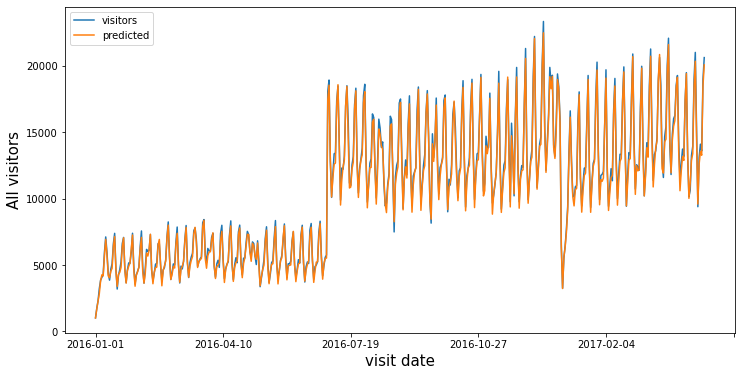

In [130]:
visitors_by_date = df.groupby(['visit_date']).agg({'visitors': np.sum})
visitors_by_date_tst_prd = df.groupby(['visit_date']).agg({'predicted': np.sum})

fig,ax = plt.subplots(figsize=(12,6))
visitors_by_date.plot(kind='line', ax=ax)
visitors_by_date_tst_prd.plot(kind='line', ax=ax)

plt.ylabel('All visitors',fontsize=15)
plt.xlabel('visit date',fontsize=15)
plt.show()

In [137]:
pred = model.predict(x_test)
print(len(pred))

# pred = np.expm1(pred)
pred = np.clip(pred, a_min=1, a_max=None)
pred = pred.astype(int)

10000


In [138]:
df_test = air_visit[air_visit_count_:]
df_test['predicted'] = pred


/var/folders/3f/t2z7k3f5209_6hp246wpbpg40000gn/T/ipykernel_28886/2445910533.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predicted'] = pred


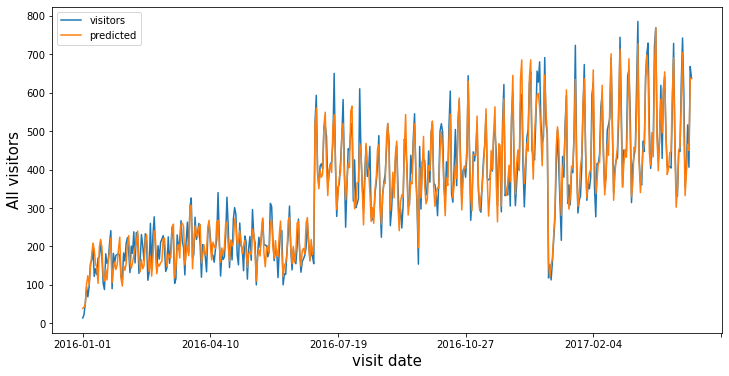

In [139]:
visitors_by_date = df_test.groupby(['visit_date']).agg({'visitors': np.sum})
visitors_by_date_tst_prd = df_test.groupby(['visit_date']).agg({'predicted': np.sum})

fig,ax = plt.subplots(figsize=(12,6))
visitors_by_date.plot(kind='line', ax=ax)
visitors_by_date_tst_prd.plot(kind='line', ax=ax)

plt.ylabel('All visitors',fontsize=15)
plt.xlabel('visit date',fontsize=15)
plt.show()

In [78]:
# save to JSON
model.save_model("model_xgboost_test.json")

# save to text format
model.save_model("model_xgboost_test.txt")


# Filling Missing Values

In [56]:
x_train_without_miss = x_train
x_train_without_miss['air_reserve_visitors'] = x_train_without_miss['air_reserve_visitors'].fillna(0)
x_train_without_miss['hpg_reserve_visitors'] = x_train_without_miss['hpg_reserve_visitors'].fillna(0)

In [57]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()
dtr.fit(x_train_without_miss, y_train)


DecisionTreeRegressor()

<AxesSubplot:>

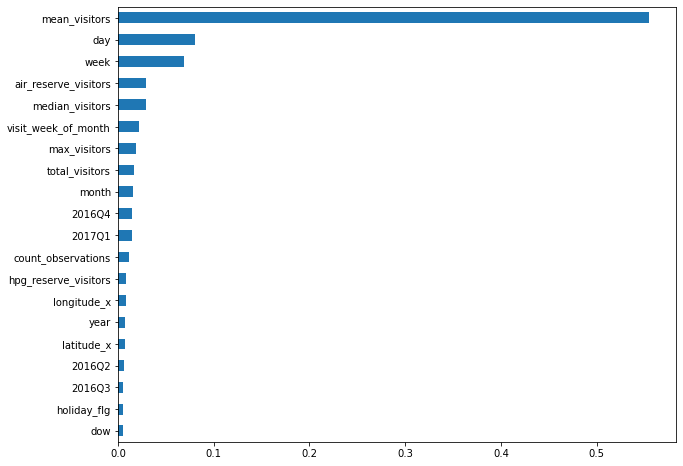

In [58]:
top_20 = pd.Series(dtr.feature_importances_, index = x_train_without_miss.columns).nlargest(20)
top_20.sort_values().plot(kind='barh', figsize=(10, 8))

In [59]:
x_train

,holiday_flg,latitude_x,longitude_x,air_reserve_visitors,hpg_reserve_visitors,day,dow,year,month,week,...,Toyotamakita,Tsukiji,Tōyō,Tōyōchō,Yasuda,Ōgimachi,Ōhiraki,Ōjihonchō,Ōtedōri,Ōtemachi
0,0,35.658068,139.751599,0.0,0.0,13,2,2016,1,2,...,0,0,0,0,0,0,0,0,0,0
1,0,35.658068,139.751599,0.0,0.0,14,3,2016,1,2,...,0,0,0,0,0,0,0,0,0,0
2,0,35.658068,139.751599,0.0,0.0,15,4,2016,1,2,...,0,0,0,0,0,0,0,0,0,0
3,0,35.658068,139.751599,0.0,0.0,16,5,2016,1,2,...,0,0,0,0,0,0,0,0,0,0
4,0,35.658068,139.751599,0.0,0.0,18,0,2016,1,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252103,0,35.653217,139.711036,0.0,0.0,18,1,2017,4,16,...,0,0,0,0,0,0,0,0,0,0
252104,0,35.653217,139.711036,0.0,0.0,19,2,2017,4,16,...,0,0,0,0,0,0,0,0,0,0
252105,0,35.653217,139.711036,0.0,0.0,20,3,2017,4,16,...,0,0,0,0,0,0,0,0,0,0
252106,0,35.653217,139.711036,0.0,0.0,21,4,2017,4,16,...,0,0,0,0,0,0,0,0,0,0


In [60]:
y_train

0         25
1         32
2         29
3         22
4          6
          ..
252103     6
252104     6
252105     7
252106     8
252107     5
Name: visitors, Length: 252108, dtype: int64

In [61]:
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable


In [62]:
from sklearn.preprocessing import StandardScaler

# scaled
std = StandardScaler() 
x_tr_std = std.fit_transform(x_train)

In [63]:
x_train.shape

(252108, 215)

In [64]:
y_train_ = np.array(y_train)
y_train_ = y_train_.reshape(-1, 1)

In [65]:
std1 = StandardScaler()
y_train = std1.fit_transform(y_train_)

In [66]:
y_train

array([[ 0.24027242],
       [ 0.65800894],
       [ 0.478979  ],
       ...,
       [-0.83390719],
       [-0.77423055],
       [-0.95326049]])

In [67]:
x_train = x_tr_std

In [68]:
x_train_arr = np.array(x_train)

In [69]:
# reshape input
x_tr_lstm = x_train_arr.reshape(x_train_arr.shape[0], 1, x_train_arr.shape[1])
print("x_train: ", x_tr_lstm.shape)



x_train:  (252108, 1, 215)


In [70]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
#         self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [71]:
x_tr_l = Variable(torch.Tensor(np.array(x_tr_lstm)))

In [72]:
x_tr_l.shape

torch.Size([252108, 1, 215])

In [73]:
x_tr_l = x_tr_l.reshape(252108, 215,1)

In [74]:
y_train

array([[ 0.24027242],
       [ 0.65800894],
       [ 0.478979  ],
       ...,
       [-0.83390719],
       [-0.77423055],
       [-0.95326049]])

In [75]:
y_train_arr = np.array(y_train)


In [76]:
y_train_arr

array([[ 0.24027242],
       [ 0.65800894],
       [ 0.478979  ],
       ...,
       [-0.83390719],
       [-0.77423055],
       [-0.95326049]])

In [77]:
y_train_arr.shape

(252108, 1)

In [78]:
y_tr_l = Variable(torch.Tensor(np.array(y_train_arr)))

In [79]:
y_tr_l.shape

torch.Size([252108, 1])

In [80]:
y_tr_l = y_tr_l.reshape(252108, 1)

In [81]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        pred  = torch.expm1(pred)
        actual = torch.expm1(actual)
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

In [82]:
num_epochs = 100
learning_rate = 0.01 

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

l = LSTM(num_classes, input_size, hidden_size, num_layers)
o = l(x_tr_l)

In [83]:
print(y_tr_l)

tensor([[ 0.2403],
        [ 0.6580],
        [ 0.4790],
        ...,
        [-0.8339],
        [-0.7742],
        [-0.9533]])


In [84]:
# criterion = torch.nn.MSELoss()    # mean-squared error for regression
criterion = RMSLELoss()

loss = criterion(o, y_tr_l)

In [86]:
loss

tensor(1.0106, grad_fn=<SqrtBackward0>)

In [88]:
num_epochs = 200
learning_rate = 0.001 

input_size = 1
hidden_size = 4
num_layers = 4

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
# criterion = RMSLELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(x_tr_l)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, y_tr_l)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 5 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

/Users/prajin/miniforge3/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([252108, 1])) that is different to the input size (torch.Size([1008432, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (1008432) must match the size of tensor b (252108) at non-singleton dimension 0

In [405]:
lstm.eval()

LSTM(
  (lstm): LSTM(1, 2, batch_first=True)
  (fc): Linear(in_features=2, out_features=1, bias=True)
)

In [407]:
res = lstm(x_tr_l)

tensor([[-0.0029],
        [-0.0029],
        [-0.0029],
        ...,
        [-0.0029],
        [-0.0029],
        [-0.0029]], grad_fn=<AddmmBackward0>)